# Seasonal flu vaccines
This exericse predicts whether individuals will receive their seasonal flu vaccines by fitting machine learning models to the U.S. National 2009 H1N1 Flu Survey data. Data is provided courtesy of the United States National Center for Health Statistics to DrivenData for a practice competition (https://www.drivendata.org/competitions/66/flu-shot-learning/).

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

#support vector classifier
from sklearn.svm import SVC

#random forest classifier
from sklearn.ensemble import RandomForestClassifier

#deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

#performance metrics
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

In [2]:
#suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Data checking and cleaning
In this section, read the csv files into pandas Dataframe and perform any necessary checking and cleaning steps. 

In [3]:
#reading training_set_labels 
df_labels = pd.read_csv("./Resources/training_set_labels.csv", index_col = "respondent_id")
df_labels.head(3)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0


In [4]:
#reading training_set_features
df_features = pd.read_csv("./Resources/training_set_features.csv", index_col = "respondent_id")
df_features.head(3)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo


In [5]:
#combine both dataframes into a single dataframe
df_vaccine = pd.concat([df_labels,df_features],axis = 1)
df_vaccine.head(3)

,h1n1_vaccine,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,0,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo


In [6]:
#identify h1n1 specific columns
h1n1 = df_vaccine.filter(like = "h1n1").columns
display(h1n1)

#drop h1n1 specific data
df_vaccine.drop(columns = h1n1, inplace = True)

Index(['h1n1_vaccine', 'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc'],
      dtype='object')

In [7]:
#check for missing values
df_vaccine.isnull().sum()

seasonal_vaccine                   0
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
hhs_geo_region                     0
census_msa                         0
household_adults                 249
h

In [8]:
#drop columns with more than 40% missing value
df_vaccine.drop(columns = ["health_insurance","employment_industry","employment_occupation"], inplace= True)

In [9]:
df_vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   seasonal_vaccine             26707 non-null  int64  
 1   behavioral_antiviral_meds    26636 non-null  float64
 2   behavioral_avoidance         26499 non-null  float64
 3   behavioral_face_mask         26688 non-null  float64
 4   behavioral_wash_hands        26665 non-null  float64
 5   behavioral_large_gatherings  26620 non-null  float64
 6   behavioral_outside_home      26625 non-null  float64
 7   behavioral_touch_face        26579 non-null  float64
 8   doctor_recc_seasonal         24547 non-null  float64
 9   chronic_med_condition        25736 non-null  float64
 10  child_under_6_months         25887 non-null  float64
 11  health_worker                25903 non-null  float64
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

## Data Preprocessing
**Review the DataFrame, looking for categorical variables that will need to be encoded, as well as columns that could eventually define your features and target variables.**

In [10]:
df_features = df_vaccine.drop(columns = ["seasonal_vaccine"]).copy()
df_features.head(3)

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0


In [11]:
# Create and display the list of numerical variables 
numerical_variables = list(df_features.dtypes[df_features.dtypes != "object"].index)
numerical_variables

['behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [12]:
# Create a list of categorical variables 
categorical_variables = list(df_features.dtypes[df_features.dtypes == "object"].index)

# Display the categorical variables list
categorical_variables

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

**Replacing missing values with most frequent value**

In [13]:
#define strategy for replacing missing values
imp_mostfreq = SimpleImputer(strategy = "most_frequent", missing_values = np.nan)

In [14]:
#replacing missing values
df_numerical_variables_imputed = pd.DataFrame(imp_mostfreq.fit_transform(df_features[numerical_variables].loc[:,:]),
                                   columns = df_features[numerical_variables].columns)

df_numerical_variables_imputed.head()

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,4.0,1.0,0.0,0.0
4,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,4.0,1.0,0.0


In [15]:
#replacing missing values
df_categorical_variables_imputed = pd.DataFrame(imp_mostfreq.fit_transform(df_features[categorical_variables].loc[:,:]),
                                   columns = df_features[categorical_variables].columns)

df_categorical_variables_imputed.head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City"
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City"
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"


**Encode the dataset’s categorical variables using OneHotEncoder, and then place the encoded variables into a new DataFrame.**

In [16]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse = False)

In [17]:
# Encode the categorcal variables using OneHotEncoder
encoded_data = enc.fit_transform(df_categorical_variables_imputed)

In [18]:
# Create a DataFrame with the encoded variables
encoded_df = pd.DataFrame(encoded_data,
                          columns = enc.get_feature_names_out(categorical_variables)
                         )

# Review the DataFrame
encoded_df.head()

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,...,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


**Add the original DataFrame’s numerical variables to the DataFrame containing the encoded variables.**

In [19]:
# Add the numerical variables from the original DataFrame to the one-hot encoding DataFrame
encoded_df = pd.concat([encoded_df, df_numerical_variables_imputed], axis = 1)

# Review the Dataframe
encoded_df.head(3)

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,...,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0


**Define features and target variables**

In [20]:
#define features set X
X = encoded_df.copy()

# Review the features DataFrame
X.head()

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,...,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,5.0,4.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,3.0,1.0,4.0,1.0,0.0


In [21]:
#define target variable y
y = df_vaccine["seasonal_vaccine"].copy()
y[:5]

respondent_id
0    0
1    1
2    0
3    1
4    0
Name: seasonal_vaccine, dtype: int64

In [22]:
y.value_counts()

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

**Split dataset into training and testing dataset**

In [23]:
# Creating training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

In [24]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Build and Train Machine Learning Models
Three models are considered:
1. Support vector classifier model
2. Random forest classifier model
3. Deep learning model

### 1. Support Vector Classifer Model

In [25]:
# From SVM, instantiate SVC classifier model instance
model_svm = SVC(random_state = 1)

# Fit the model to the data using the training data
model1 = model_svm.fit(X_train_scaled, y_train)

# Use the testing data to make the model predictions
y_pred_svm = model1.predict(X_test_scaled)

# Review the model's predicted values
y_pred_svm[:10]

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int64)

In [26]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_svm = classification_report(y_test, y_pred_svm)
print(testing_report_svm)

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      3540
           1       0.75      0.73      0.74      3137

    accuracy                           0.76      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.76      0.76      0.76      6677



### 2. Random Forest Classifer Model

In [27]:
# instantiate random forest classifier model instance
model_rf= RandomForestClassifier()

# Fit the model to the data using the training data
model2 = model_rf.fit(X_train_scaled, y_train)

# Use the testing data to make the model predictions
y_pred_rf = model2.predict(X_test_scaled)

# Review the model's predicted values
y_pred_rf[:10]

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int64)

In [28]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_rf = classification_report(y_test, y_pred_rf)
print(testing_report_rf)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      3540
           1       0.76      0.73      0.74      3137

    accuracy                           0.76      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.76      0.76      0.76      6677



### 3. Deep learning model

In [29]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

54

In [30]:
# Define the number of neurons in the output layer
number_output_neurons = 1

In [31]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 = (number_input_features + 1)//2

# Review the number hidden nodes in the first layer
hidden_nodes_layer1

27

In [32]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = (hidden_nodes_layer1 + 1)//2

# Review the number hidden nodes in the second layer
hidden_nodes_layer2

14

In [33]:
# Create the Sequential model instance
nn = Sequential()

In [34]:
# Add the first hidden layer
nn.add(Dense(units = hidden_nodes_layer1, activation = "relu", input_dim = number_input_features))

In [35]:
# Add the second hidden layer
nn.add(Dense(units = hidden_nodes_layer2, activation = "relu"))

In [36]:
# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units = number_output_neurons, activation = "sigmoid"))

In [37]:
# Display the Sequential model summary
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 27)                1485      
                                                                 
 dense_1 (Dense)             (None, 14)                392       
                                                                 
 dense_2 (Dense)             (None, 1)                 15        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Compile the Sequential model
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics =["accuracy"])

In [39]:
# Fit the model using 50 epochs and the training data
nn.fit(X_train_scaled, y_train, epochs = 50)

Epoch 1/50
626/626 [==============================] - 3s 3ms/step - loss: 0.5413 - accuracy: 0.7257
Epoch 2/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4840 - accuracy: 0.7759
Epoch 3/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4757 - accuracy: 0.7803
Epoch 4/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4704 - accuracy: 0.7836
Epoch 5/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4669 - accuracy: 0.7823
Epoch 6/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4640 - accuracy: 0.7858
Epoch 7/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4614 - accuracy: 0.7875
Epoch 8/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4594 - accuracy: 0.7898
Epoch 9/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4570 - accuracy: 0.7898
Epoch 10/50
626/626 [==============================] - 2s 3ms/step - loss: 0.4557 - accuracy: 0.7911

In [40]:
# Use the testing data to make the model predictions
y_pred_nn = (nn.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn[:10]

209/209 [==============================] - 1s 2ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0]], dtype=int64)

In [41]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn = classification_report(y_test, y_pred_nn)
print(testing_report_nn)

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      3540
           1       0.74      0.73      0.74      3137

    accuracy                           0.75      6677
   macro avg       0.75      0.75      0.75      6677
weighted avg       0.75      0.75      0.75      6677



In [42]:
#compare roc_auc_score
display(roc_auc_score(y_test, y_pred_svm))
display(roc_auc_score(y_test, y_pred_rf))
display(roc_auc_score(y_test, y_pred_nn))

0.7593020878920989

0.7613662969226418

0.7514753741114346

In [43]:
#define a function to plot roc_curve
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

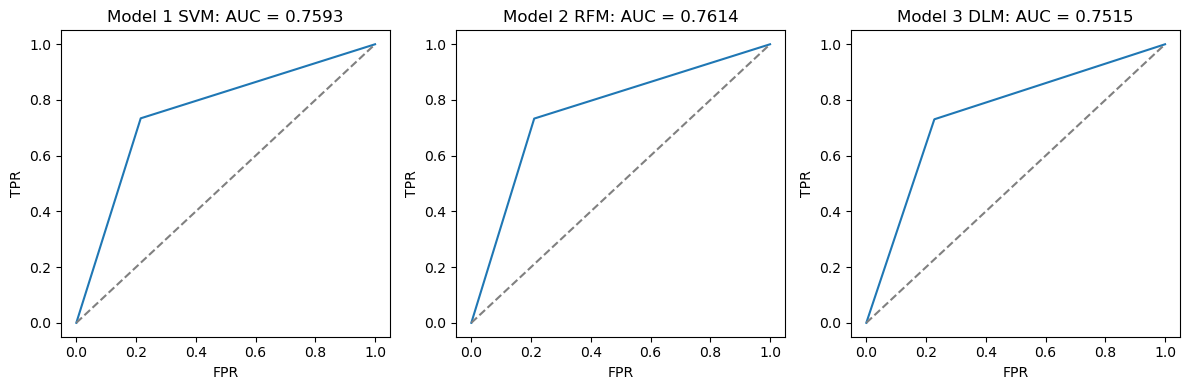

In [44]:
#plot roc_curve for each model
fig, ax = plt.subplots(1, 3, figsize = (12,4))

plot_roc(y_test, y_pred_svm, "Model 1 SVM", ax=ax[0])
plot_roc(y_test, y_pred_rf, "Model 2 RFM", ax=ax[1])
plot_roc(y_test, y_pred_nn, "Model 3 DLM", ax=ax[2])

fig.tight_layout()